# Bio physics

Biophysics Exam\
Tuur Rumes \
Fysica en sterrenkunde bach 2 

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib.lines import Line2D
import sympy 
import matplotlib.patches as mpatches
from sympy.solvers import solve
from sympy import Symbol, im
from matplotlib import colors
import plotly.graph_objects as go
from scipy.signal import find_peaks
import mpl_toolkits.mplot3d.axes3d as p3
from sympy import solve, diff, re, im,Symbol, symbols
import matplotlib.animation as animation
import math
import random
from ipywidgets import VBox, HBox, Layout, interact, widgets, interactive, fixed, interact_manual
import warnings
warnings.filterwarnings('ignore')

## 1 The quorum sensing - nullclines

In [2]:
def get_change_vectors(K, S, gs = 0.1):
    K_prime = (80*K)/(1+100*K) - (K)/(1+K+S)
    S_prime = gs - (S)/(1+K+S)
    return K_prime ,S_prime

def K_null(S):
    return (79+80*S)/20

def S_null(K, gs):
    return gs*(1+K)/(1-gs)

### A

In [3]:
lengte = 1000
amount = 20

def plot_R(K, S, ax, scale, gs):
    K_prime, S_prime = get_change_vectors(K, S, gs)
    ax.arrow(K, S, np.sign(K_prime)*scale, 0, head_width=0.1, color='blue')

def plot_C(K, S, ax, scale, gs):
    R_prime, S_prime = get_change_vectors(K, S, gs)
    ax.arrow(K, S, 0, np.sign(S_prime)*scale, head_width=0.1, color='red')

def plot_nullclines(ax, gs, Kmin = 0, Kmax = 20, Smin = 0,Smax = 20, scale = 0.5):
    vecfuncK = np.vectorize(K_null)
    vecfuncS = np.vectorize(S_null)

    S = np.linspace(Smin, Smax, lengte)
    K = vecfuncK(S)
    ax.plot(K, S, label="K' = 0", color='blue')
    for i in range(1, lengte, amount):
        plot_C(K[i], S[i], ax, scale, gs)

    K = np.linspace(Kmin, Kmax, lengte)
    S = vecfuncS(K, gs)
    ax.plot(K, S, label="S' = 0", color='red')
    for i in range(1, lengte, amount*3):
        plot_R(K[i], S[i], ax, scale, gs)

def set_labels(title, Kmin = 0, Kmax = 20, Smin = 0,Smax = 20):
    plt.title(title)
    plt.xlabel("K")
    plt.ylabel("S")
    plt.legend()
    plt.xlim(Kmin, Kmax)
    plt.ylim(Smin, Smax)

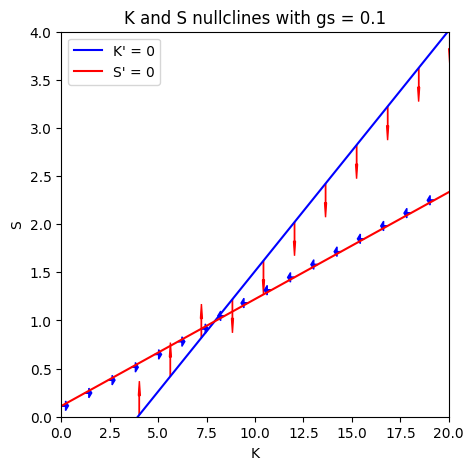

In [4]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(5, 5))

plot_nullclines(ax, 0.1, scale = 0.2)
set_labels("K and S nullclines with gs = 0.1" , Smax = 4)

In [5]:
plt.style.use('default')

def update_value(gs):
    fig, ax = plt.subplots(figsize=(5, 5))
    plot_nullclines(ax, gs)
    set_labels("K and S nullclines with variable gs")
 
interact(update_value ,gs = (0.01,0.99, 0.01), continuous_update=False)

interactive(children=(FloatSlider(value=0.5, description='gs', max=0.99, min=0.01, step=0.01), Output()), _dom…

<function __main__.update_value(gs)>

### B 

In [11]:
def determine_jacobian(Keq, Seq, gs):
    K, S = symbols("K, S")
    K_prime, S_prime = get_change_vectors(K, S, gs)
    sub = [(K, Keq),(S, Seq)]
    
    Jac = np.zeros((2, 2))
    Jac[0, 0] = diff(K_prime, K).subs(sub)
    Jac[0, 1] = diff(K_prime, S).subs(sub)
    Jac[1, 0] = diff(S_prime, K).subs(sub)
    Jac[1, 1] = diff(S_prime, S).subs(sub)
    
    eig_values = LA.eig(Jac)
    
    return Jac, eig_values[0][0], eig_values[0][1]

In [17]:
sol = []
K, S = symbols("K, S")
Gs = np.linspace(0.001, 0.999, 200)

for gs in Gs:
    sol.append(solve(get_change_vectors(K, S, gs), [K, S]))
    
def color_picker(eq1, eq2, gs):
    _, eig1, eig2 = determine_jacobian(eq1, eq2, gs)
    
    if np.iscomplex(eig1) or np.iscomplex(eig2):
        print('change code!!!')
    
    elif eig1 < 0 and eig2 < 0:
        return 'green'
    elif eig1 > 0 and eig1 > 0:
        return 'red'
    else:
        return 'orange'

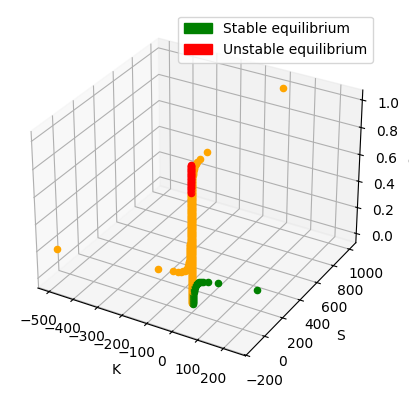

In [18]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i, eqs in enumerate(sol):
    for eq in eqs:
        color = color_picker(eq[0], eq[1], Gs[i])
        ax.scatter(eq[0], eq[1], Gs[i], c = color)

stable = mpatches.Patch(color='red', label='Unstable equilibrium')
unstable = mpatches.Patch(color='green', label='Stable equilibrium')
ax.set_xlabel('K')
ax.set_ylabel('S')
ax.set_zlabel('gs')
ax.legend(handles=[unstable, stable])
plt.show()

### C

In [9]:
%matplotlib inline 

## 2 The Rossler system

In [19]:
plt.rcParams['text.usetex'] = False
def change_vector(x, y, z, a=0.1, b=0.1, c=0.5):
    X_prime = -y -z
    Y_prime = x + a*y
    Z_prime = b + x*z - c*z
    return X_prime, Y_prime, Z_prime

### A

In [20]:
def Runge_Kunta(x, y, z ,h = 0.1, a=0.1, b=0.1, c=0.5):
    kn1, Ln1, pn1  = change_vector(x, y, z, a, b, c)
    kn2, Ln2, pn2 = change_vector(x + (h/2)*kn1, y + (h/2)*Ln1, z + (h/2)*pn1, a, b, c)
    kn3, Ln3, pn3 = change_vector(x + (h/2)*kn2, y + (h/2)*Ln2, z + (h/2)*pn2, a, b, c)
    kn4, Ln4, pn4 = change_vector(x + (h)*kn3  , y + (h)*Ln3  , z + (h)*pn3  , a, b, c)
    
    X_n1 = x + (h/6)*(kn1 + 2*kn2 + 2*kn3 + kn4)
    Y_n1 = y + (h/6)*(Ln1 + 2*Ln2 + 2*Ln3 + Ln4)
    Z_n1 = z + (h/6)*(pn1 + 2*pn2 + 2*pn3 + pn4)
    
    return X_n1, Y_n1, Z_n1

In [21]:
def integrate_RK(X0, lengte, acc = 0.1,a = 0.1, b = 0.1, c=0.5):
    sol = [[X0[0]],[X0[1]],[X0[2]]]

    for i in range(int(lengte)):
        x = sol[0][i]
        y = sol[1][i]
        z = sol[2][i]
        sol[0].append(Runge_Kunta(x, y, z ,h = acc, a = a, b = b, c = c)[0])
        sol[1].append(Runge_Kunta(x, y, z ,h = acc, a = a, b = b, c = c)[1])
        sol[2].append(Runge_Kunta(x, y, z ,h = acc, a = a, b = b, c = c)[2])
        
    return sol[0], sol[1], sol[2]

### B

In [22]:
def euler_int(x0 ,y0, z0,functie ,lengte ,h = 0.01, a = 0.1, b = 0.1, c=0.5):
    lengte = int(lengte)
    x = np.zeros(lengte)
    y = np.zeros(lengte)
    z = np.zeros(lengte)
    x[0] = x0
    y[0] = y0
    z[0] = z0
    for i in range(0, lengte - 1):
        x[i + 1] = x[i] + h*functie(x[i] ,y[i], z[i], a = a, b = b, c = c)[0]
        y[i + 1] = y[i] + h*functie(x[i] ,y[i], z[i], a = a, b = b, c = c)[1]
        z[i + 1] = z[i] + h*functie(x[i] ,y[i], z[i], a = a, b = b, c = c)[2]
    return x, y, z

In [23]:
lengte = 100000
solx, soly, solz = euler_int(1, 1, 1, change_vector, lengte, h = 0.01)

X0 = [1, 1, 1]
x, y, z = integrate_RK(X0, lengte ,a = 0.1, b =0.1, c = 0.5)

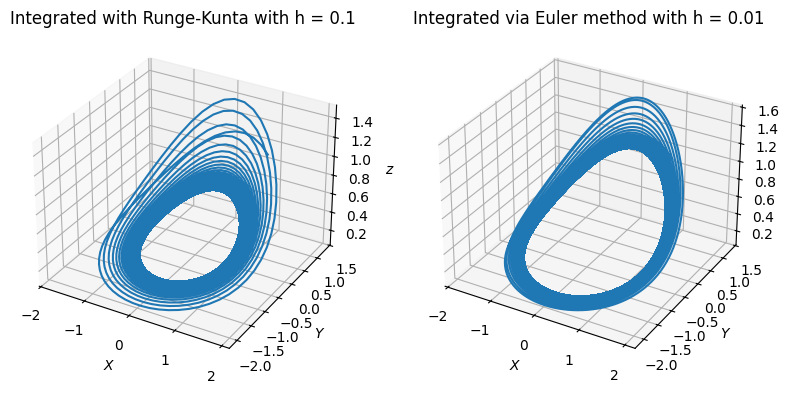

In [24]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot3D(x, y, z)
ax.set_title('Integrated with Runge-Kunta with h = 0.1')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$z$')


ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_title('Integrated via Euler method with h = 0.01')
ax.plot3D(solx, soly, solz)
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$z$')
plt.show()

In [25]:
def update_time_series(h):
    t = np.linspace(0,100, 1000)
    t_ = np.linspace(0,100, int(1000/(10*h)))
    X0 = [1, 1, 1]

    solx, soly, solz = euler_int(1, 1, 1, change_vector, 1000/(10*h) , h = h)
    x, y, z = integrate_RK(X0, 1000-1,a = 0.1, b =0.1, c = 0.5)

    fig, ax = plt.subplots(3,1,figsize=(10,6))
    ax[0].plot(t, x, c = 'blue', label = 'Runge-Kunte')
    ax[0].plot(t_, solx, c = 'red', label = 'Euler')
    ax[0].set_ylabel('X')
        
    ax[1].plot(t, y, c = 'blue')
    ax[1].plot(t_, soly, c = 'red')
    ax[1].set_ylabel('Y')
        
    ax[2].plot(t, z, c = 'blue')
    ax[2].plot(t_, solz, c = 'red')
    ax[2].set_ylabel('Z')
    ax[2].set_xlabel('T')
    
    ax[0].legend(bbox_to_anchor=(1, 1))
    plt.show()

In [26]:
interact(update_time_series ,h = (0.001,0.038, 0.001), continuous_update=False)

interactive(children=(FloatSlider(value=0.019000000000000003, description='h', max=0.038, min=0.001, step=0.00…

<function __main__.update_time_series(h)>

### C

In [ ]:
def update_c(c):
    X0 = [1, 1, 0]
    lengte = 50000
    x, y, z = integrate_RK(X0, lengte, acc = 0.01 ,a = 0.1, b =0.1, c = c)
    
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection='3d')
    ax.plot3D(x, y, z)
    ax.set_title('road to chaos')
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$z$')
    plt.show()

interact(update_c ,c = (0.3,30, 0.1), continuous_update=False)

interactive(children=(FloatSlider(value=15.100000000000001, description='c', max=30.0, min=0.3), Output()), _d…

<function __main__.update_c(c)>

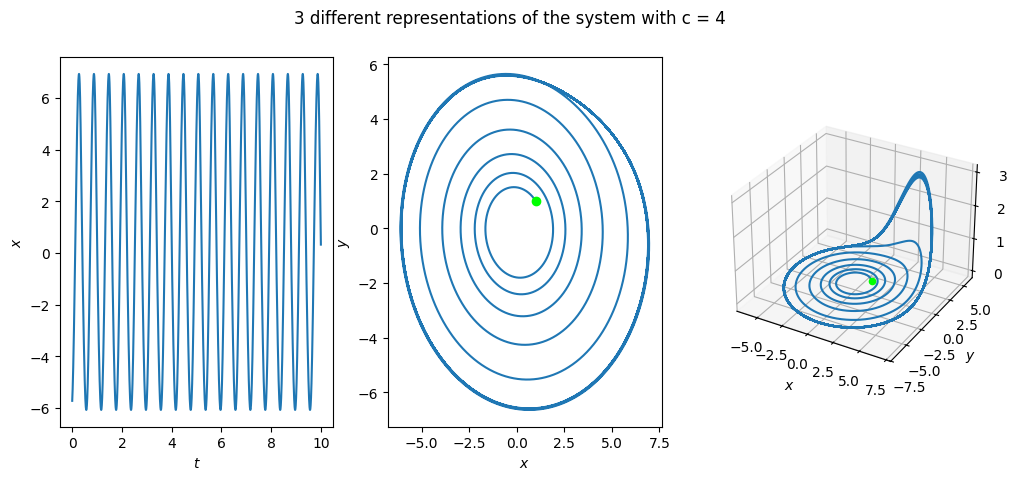

In [28]:
def time_series_plot_3D_and_2D(c, X0, lengte,tit,  acc = 0.001):
    fig = plt.figure(figsize=plt.figaspect(0.4))
    x, y, z = integrate_RK(X0, lengte,acc = acc,  c = c)

    t = np.linspace(0, 10, 100000)
    ax = fig.add_subplot(1, 3, 1)
    x_ = x[100000:200000]
    ax.plot(t, x_)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    
    ax = fig.add_subplot(1, 3, 2)
    ax.plot(x, y)
    ax.scatter(x[0], y[0], c = 'lime', zorder=3)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    ax.scatter(x[0], y[0], z[0], c = 'lime', zorder=3)
    ax.plot3D(x, y, z)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$z$')
    
    fig.suptitle(tit)
    plt.show()
    
time_series_plot_3D_and_2D(4, [1, 1, 0] ,500000, '3 different representations of the system with c = 4')

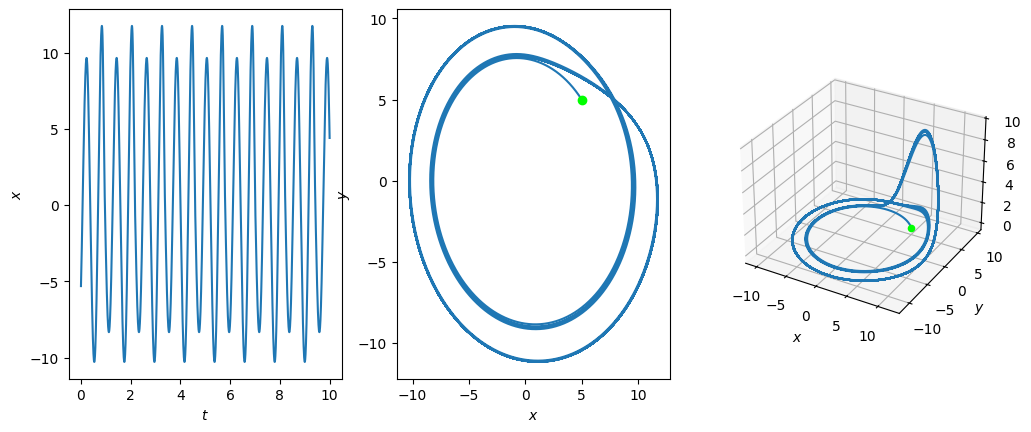

In [29]:
time_series_plot_3D_and_2D(7, [5, 5, 0] ,500000, '')

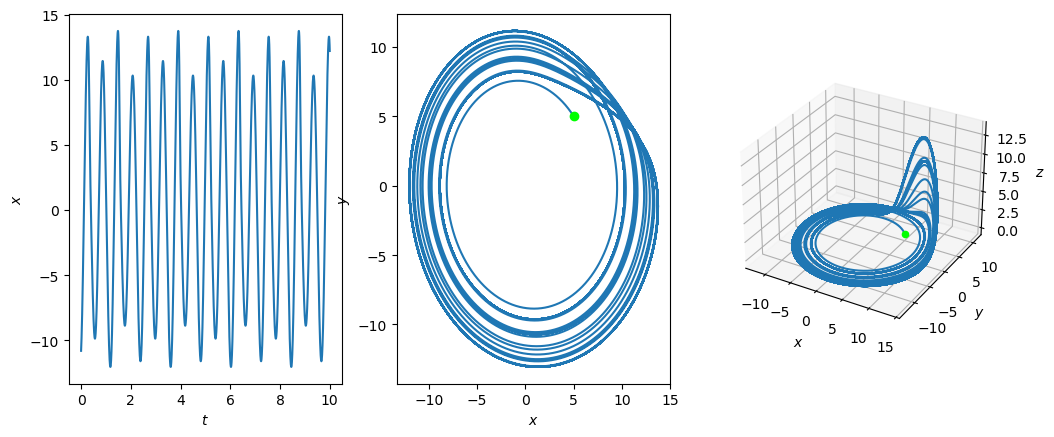

In [65]:
time_series_plot_3D_and_2D(8.3, [5, 5, 0] ,500000, '')

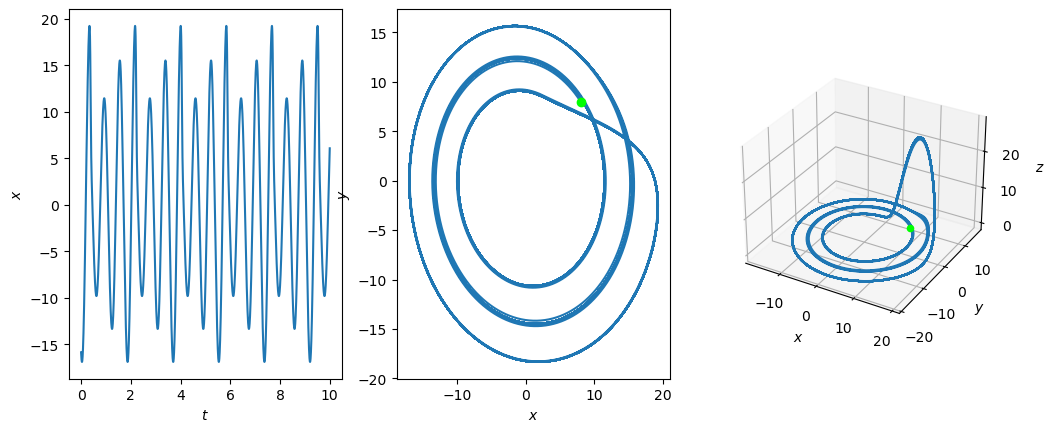

In [66]:
time_series_plot_3D_and_2D(12, [8, 8, 0] ,500000, '')

### D

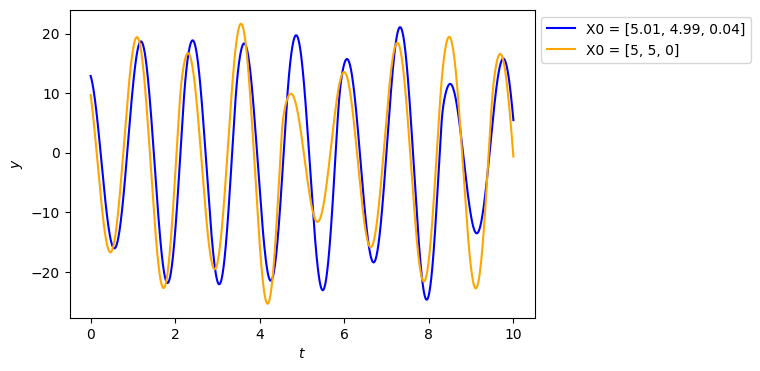

In [30]:
eps = 0.01
X0 = [5, 5, 0]
X0_ = [X0[0]+eps, X0[1]-eps, X0[2]+4*eps]

_, y, _ = integrate_RK(X0, 100000-1 ,acc = 0.01,  c = 17)
_, y_, _ = integrate_RK(X0_, 100000-1 ,acc = 0.01,  c = 17)
y, y_ = y[50000:55000], y_[50000:55000]

fig, ax = plt.subplots(figsize = (6, 4))
t = np.linspace(0, 10, 5000)
ax.plot(t, y_, label = f'X0 = {X0_}', c = 'blue')
ax.plot(t, y, label = f'X0 = {X0}', c = 'orange')
ax.set_xlabel('$t$')
ax.set_ylabel('$y$')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

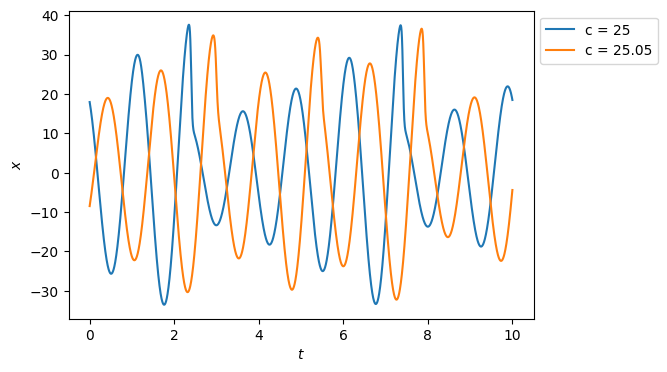

In [31]:
eps = 0.05
X0 = [5, 5, 0]
c = 25
c_ = 25 + eps

x, _, _ = integrate_RK(X0, 100000-1 ,acc = 0.01,  c = c)
x_, _, _ = integrate_RK(X0_, 100000-1 ,acc = 0.01,  c = c_)
x, x_ = x[50000:55000], x_[50000:55000]

fig, ax = plt.subplots(figsize = (6, 4))
t = np.linspace(0, 10, 5000)
ax.plot(t, x, label = f'c = {c}')
ax.plot(t, x_, label = f'c = {c+eps}')
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### E

In [32]:
B = np.linspace(0.1,4, 3000)
X_max = [] 

X_diff_B = []
for b in B:
    X_diff_B.append(integrate_RK([10,10,0], 30000,acc = 0.01,  b = b, c = 15)[0]) 

for X in X_diff_B:
    maximum = find_peaks(X)[0]
    for i in maximum:
        X_max.append(X[i])

KeyboardInterrupt: 

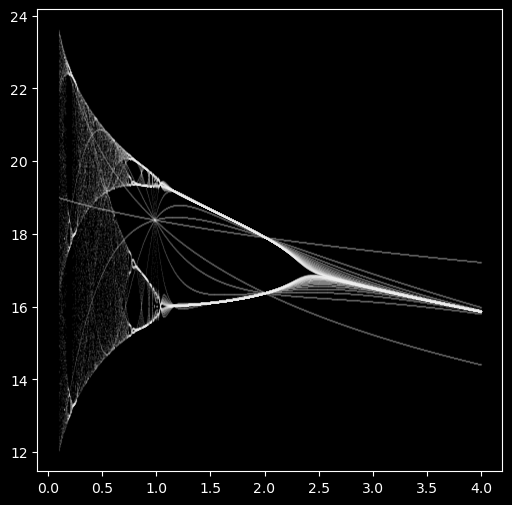

In [81]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize = (6,6))

B = np.linspace(0.1,4, len(X_max))
ax.plot(B, X_max, '^', color= 'white' , markersize = 0.013)
plt.show()

In [33]:
C = np.linspace(2,30, 3000)
X_max_C = [] 

X_diff_C = []
for c in C:
    X0 = [c, c, c]
    X_diff_C.append(integrate_RK(X0, 30000,acc = 0.01,  c = c)[0])

for X in X_diff_C:
    maximum = find_peaks(X)[0]
    for i in maximum:
        X_max_C.append(X[i])

KeyboardInterrupt: 

In [ ]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize = (8,8))

C = np.linspace(2,30, len(X_max_C))
ax.plot(C, X_max_C, '^', color= 'white' , alpha=0.6, markersize = 0.013)

# 3 A new type of bifrucation

In [34]:
def radial_eq(r, mu = 1):
    R_prime = mu*r + np.power(r, 3) - np.power(r, 5)
    return R_prime

### A

In [35]:
def equilibium(mu):
    eq1 =   [0]*lengte
    eq2 =   (np.sqrt(  (1-np.sqrt(  (4*mu + 1)+0j   ))+0j  )/np.sqrt(2))
    eq3 = - (np.sqrt(  (1-np.sqrt(  (4*mu + 1)+0j   ))+0j  )/np.sqrt(2))
    eq4 =   (np.sqrt(  (1+np.sqrt(  (4*mu + 1)+0j   ))+0j  )/np.sqrt(2))
    eq5 = - (np.sqrt(  (1+np.sqrt(  (4*mu + 1)+0j   ))+0j  )/np.sqrt(2))
    return eq1, eq2, eq3, eq4, eq5

def stability(r, mu, dt=0.0000001):
    if radial_eq(r + dt, mu) >= 0:
        return 'r'
    return 'g'

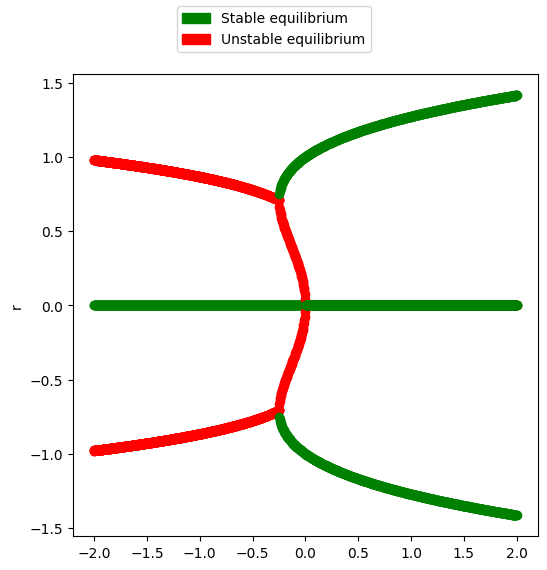

In [36]:
%matplotlib inline 
fig, ax = plt.subplots(figsize=(6, 6))

lengte = 1000
a = np.linspace(-2, 2, lengte)
color_matrix = []

for i in range(5):
    color_function = []
    for j in range(len(equilibium(a)[i])):
        color_function.append(stability(equilibium(a)[i][j] , a[j]))
    color_matrix.append(color_function)
   

for i in range(5):
    for j in range(len(equilibium(a)[i])):
        ax.scatter(a[j], equilibium(a)[i][j], c = color_matrix[i][j])
        
stable = mpatches.Patch(color='red', label='Unstable equilibrium')
unstable = mpatches.Patch(color='green', label='Stable equilibrium')
fig.legend(handles=[unstable, stable], loc = 'upper center')
ax.set_ylabel('$\mu$')   # fix LaTex
ax.set_ylabel('r')
plt.show()

### B

1
2
3
4
5
6


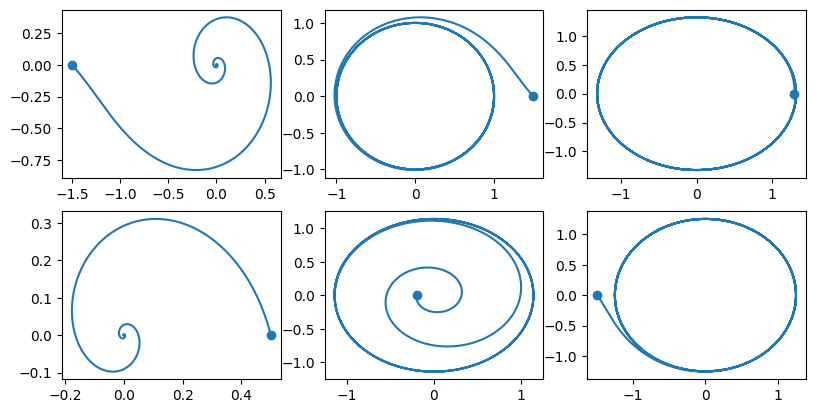

In [37]:
def integrate_radial(r0, lengte, mu, t=0.000002, cycles = 10):
    r = np.zeros(lengte)
    r[0] = r0
    for i in range(lengte-1):
        r[i + 1] = r[i] + t*radial_eq(r[i], mu=mu)
    theta =  np.linspace(0,np.pi*cycles,lengte)
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x, y


lengte = 5000000
plt.style.use('default')
fig, ax = plt.subplots(2, 3, figsize = plt.figaspect(0.5))
R0 = [-1.5, 0.5, 1.5, -0.2, 1.3, -1.5]        
mu = [-1,  -1.2, 0 ,   0.4, 1.3,  0.9]

t = 0
for i in range(3):
    for j in range(2):
        x, y = integrate_radial(R0[t], lengte, mu[t])
        ax[j][i].plot(x, y)
        ax[j][i].scatter(x[0], y[0])
        t += 1
        print(t)
        
plt.show()

In [ ]:
Zie wikipedia

### C

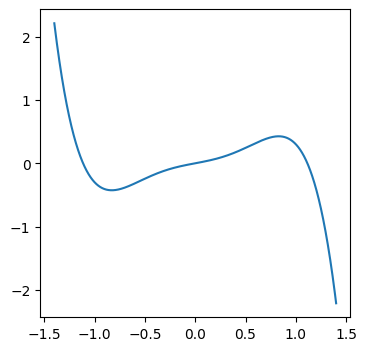

In [38]:
r = np.linspace(-1.4, 1.4, 10000)
fig, ax = plt.subplots(figsize = (4, 4))
mu = 0.3
ax.plot(r, mu*r + np.power(r, 3) - np.power(r, 5))
plt.show()